### Import Libraries

In [1]:
# Pre Processing 
import pandas as pd
import datetime as dt
import numpy as np

# Exploratory Data
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import squarify 
%matplotlib inline

# Pycaret Environment
from pycaret.regression import setup
from pycaret.regression import compare_models
from pycaret.regression import *

### Load Dataset
### California Housing Dataset

In [2]:
California = pd.read_csv('California Housing.csv')
pd.set_option('display.max_columns', None)
California.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


### Dataset Profiling

In [3]:
def dataset_profile(csv):
    print("Dataset dimension :", csv.ndim)
    print("Dataset shape :", csv.shape)
    print("Dataset size :", csv.size)

dataset_profile(California)

Dataset dimension : 2
Dataset shape : (20640, 10)
Dataset size : 206400


In [4]:
def features_types(csv):
    types = csv.dtypes.reset_index()
    types.columns = ['Features','Data Type']
    return types

features_types(California)

,Features,Data Type
0,longitude,float64
1,latitude,float64
2,housing_median_age,float64
3,total_rooms,float64
4,total_bedrooms,float64
5,population,float64
6,households,float64
7,median_income,float64
8,median_house_value,float64
9,ocean_proximity,object


### Dataset Inspection

### Missing and Blank Values Check

In [5]:
missing_data = California.isnull().sum().reset_index()
missing_data.columns = ['Features','Missing Values']
blank_data = California.apply(lambda x : x == ' ').sum().reset_index()
blank_data.columns = ['Features','Blank Values']
merged_data = pd.merge(missing_data, blank_data, on=['Features'])
merged_data['Filling Factor'] = (California.shape[0]-missing_data['Missing Values'] + California.shape[0]-blank_data['Blank Values'])/California.shape[0]*50
merged_data.sort_values(by='Filling Factor',ascending=True)

,Features,Missing Values,Blank Values,Filling Factor
4,total_bedrooms,207,0,99.498547
0,longitude,0,0,100.000000
1,latitude,0,0,100.000000
2,housing_median_age,0,0,100.000000
3,total_rooms,0,0,100.000000
5,population,0,0,100.000000
6,households,0,0,100.000000
7,median_income,0,0,100.000000
8,median_house_value,0,0,100.000000
9,ocean_proximity,0,0,100.000000


### Cross Checking Missing Values with ASSERT Statement

In [6]:
# Assert that there are no missing values in the dataframe

assert pd.notnull(California).all().all()

AssertionError: 

Interpretation
 - The above command does indeed throw an error. Hence, it is confirmed that there are missing or negative values in the dataset
 - Some of the values within dataset either missing or negative.
 - Proceed to data cleaning

### Dataset Overview

In [7]:
def initial_eda(df):
    if isinstance(df, pd.DataFrame):
        total_na = df.isna().sum().sum()
        print("Dimensions : %d rows, %d columns" % (df.shape[0], df.shape[1]))
        print("Total NA Values : %d " % (total_na))
        print("%38s %10s     %10s %10s" % ("Column Name", "Data Type", "#Distinct", "NA Values"))
        col_name = df.columns
        dtyp = df.dtypes
        uniq = df.nunique()
        na_val = df.isna().sum()
        for i in range(len(df.columns)):
            print("%38s %10s   %10s %10s" % (col_name[i], dtyp[i], uniq[i], na_val[i]))
        
    else:
        print("Expect a DataFrame but got a %15s" % (type(df)))
        
initial_eda(California)

Dimensions : 20640 rows, 10 columns
Total NA Values : 207 
                           Column Name  Data Type      #Distinct  NA Values
                             longitude    float64          844          0
                              latitude    float64          862          0
                    housing_median_age    float64           52          0
                           total_rooms    float64         5926          0
                        total_bedrooms    float64         1923        207
                            population    float64         3888          0
                            households    float64         1815          0
                         median_income    float64        12928          0
                    median_house_value    float64         3842          0
                       ocean_proximity     object            5          0


### Categorical Features

In [8]:
categorical = [var for var in California.columns if California[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n', categorical)

There are 1 categorical variables

The categorical variables are :

 ['ocean_proximity']


### Numerical Features

In [9]:
numerical = [var for var in California.columns if California[var].dtype!='O']

print('There are {} numerical variables\n'.format(len(numerical)))

print('The numerical variables are :\n\n', numerical)

There are 9 numerical variables

The numerical variables are :

 ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']


### Categorical Features Distinc Value Distribution

In [10]:
for var in categorical: 
    
    print(California[var].value_counts())

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64


### Data Cleaning : Replacing Missing Values with Median

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = SimpleImputer(strategy='most_frequent')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ])
# Fit to Dataframe
array_prepared = preprocessor.fit_transform(California)

# Converts the array to Dataframe
my_cols = numerical + categorical
California = pd.DataFrame(array_prepared, 
             columns=(list(my_cols)))

# Replace Features type to Their Correct Ones
California[numerical] = California[numerical].astype('float64')
California

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


### Cross Checking For Missing Values in Dataset

In [12]:
# Assert that there are no missing values in the dataframe

assert pd.notnull(California).all().all()

In [13]:
initial_eda(California)

Dimensions : 20640 rows, 10 columns
Total NA Values : 0 
                           Column Name  Data Type      #Distinct  NA Values
                             longitude    float64          844          0
                              latitude    float64          862          0
                    housing_median_age    float64           52          0
                           total_rooms    float64         5926          0
                        total_bedrooms    float64         1923          0
                            population    float64         3888          0
                            households    float64         1815          0
                         median_income    float64        12928          0
                    median_house_value    float64         3842          0
                       ocean_proximity     object            5          0


### Exploratory Data

In [14]:
California.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,536.838857,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,419.391878,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,297.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,643.250000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Numerical Feature Plot

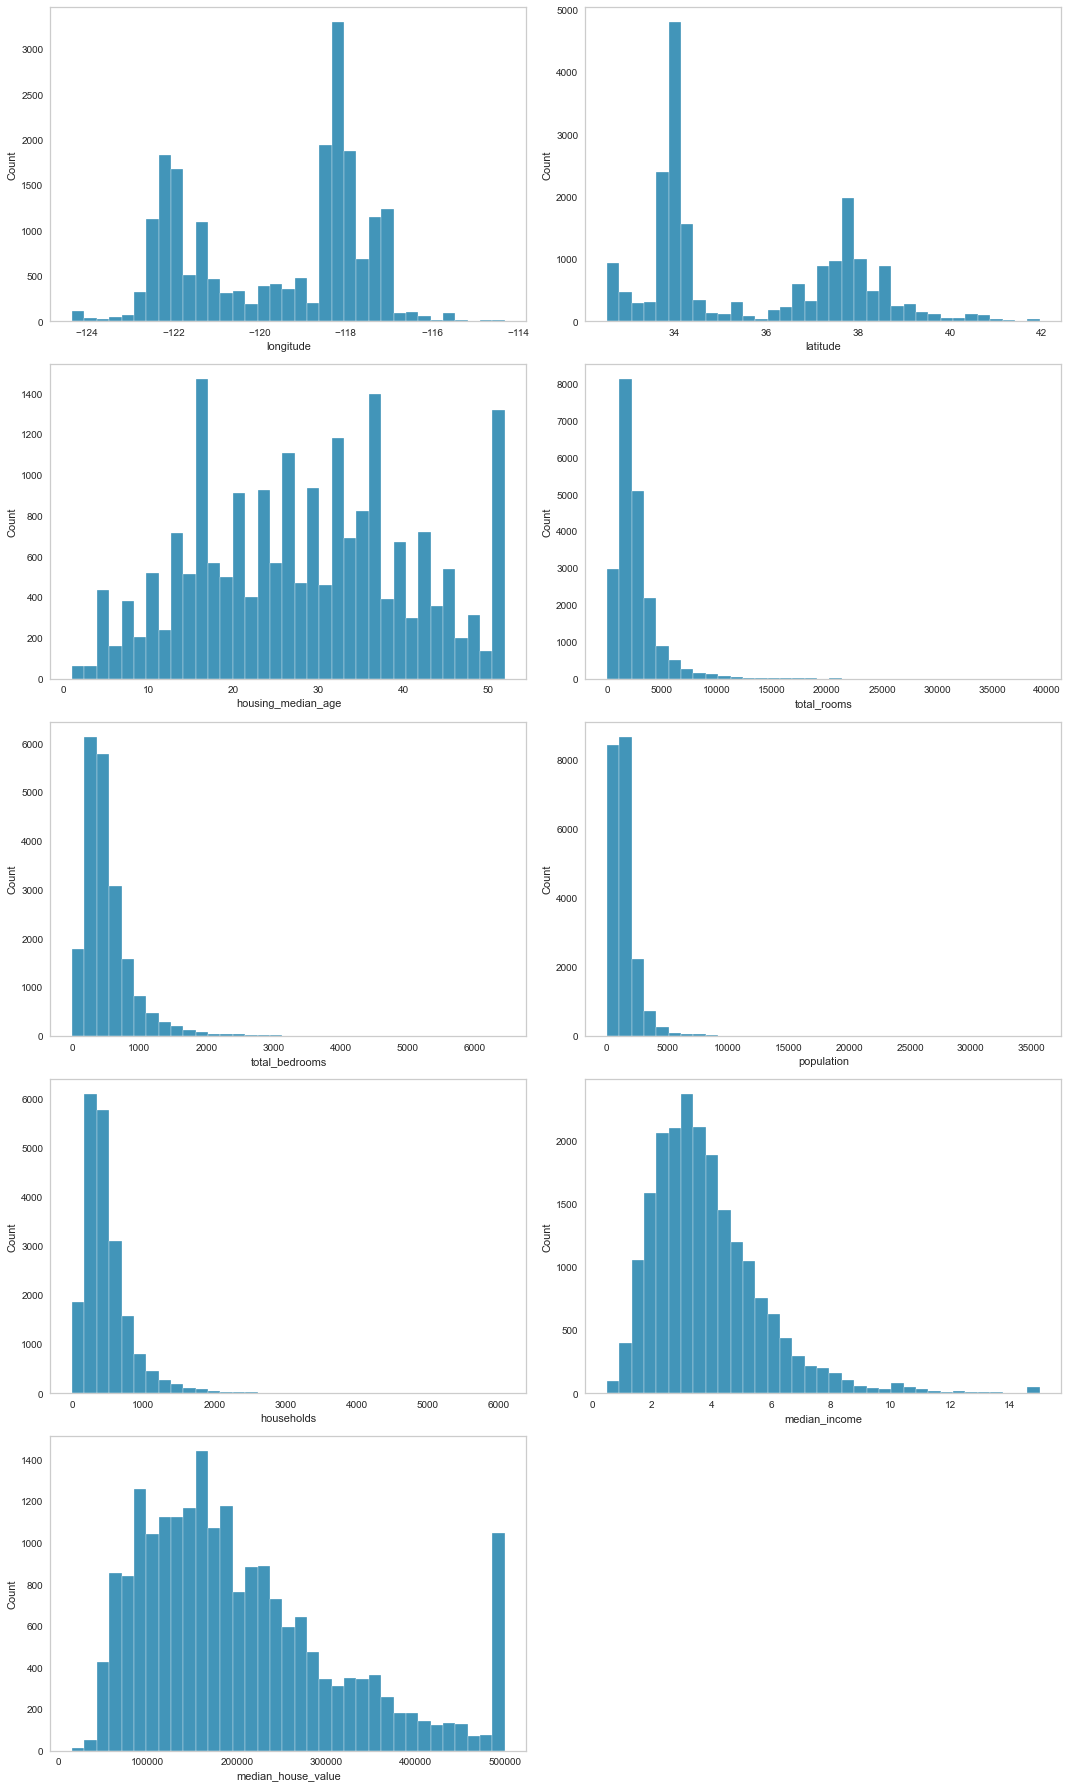

In [66]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

plt.figure(figsize=(15, 25))
for i in range(0, len(list(California[numerical]))):
    plt.subplot(5, 2, i+1)
    sns.histplot(x=California[list(California[numerical])[i]],bins = 35)
    plt.tight_layout()

### Outliers

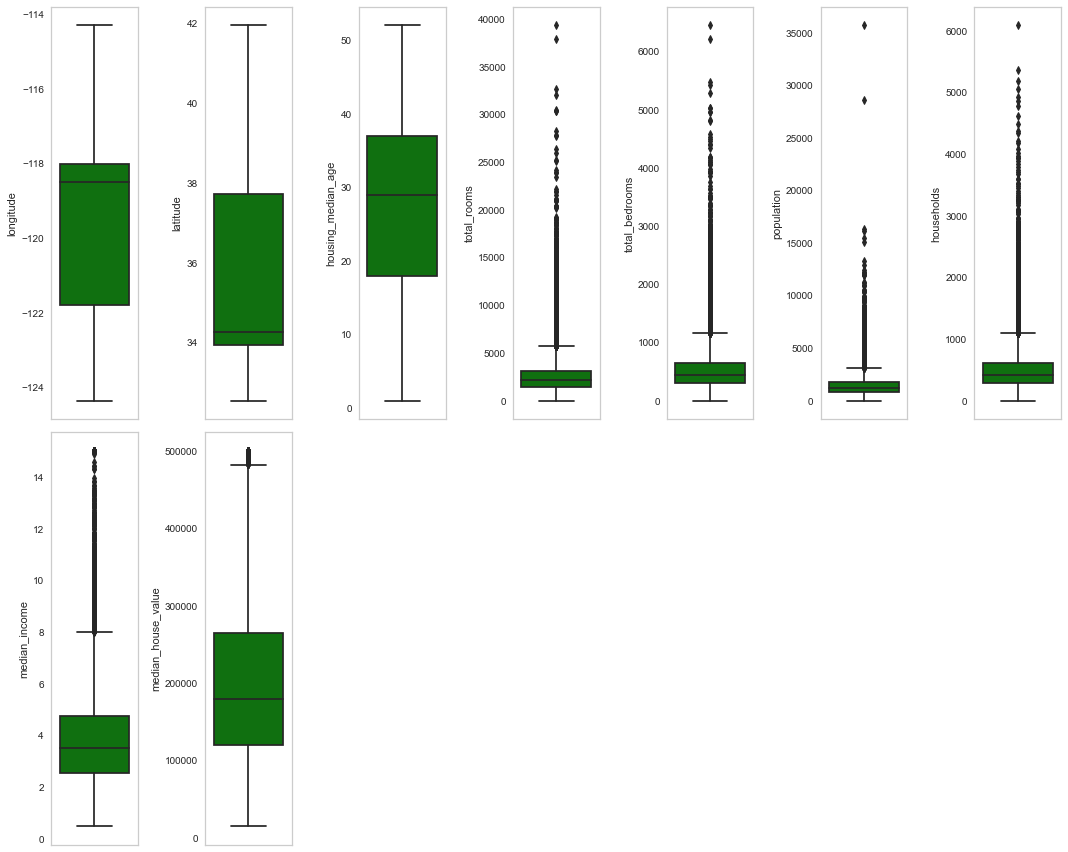

In [67]:
plt.figure(figsize=(15, 12))
for i in range(0, len(list(California[numerical]))):
    plt.subplot(2, 7, i+1)
    sns.boxplot(y=California[list(California[numerical])[i]],color='green',orient='v')
    plt.tight_layout()

### Correlation

In [68]:
# plot correlation heatmap to find out correlations

California.corr().style.format("{:.4}").background_gradient(cmap=plt.get_cmap('viridis'), axis=1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.0,-0.9247,-0.1082,0.04457,0.06912,0.09977,0.05531,-0.01518,-0.04597
latitude,-0.9247,1.0,0.01117,-0.0361,-0.06648,-0.1088,-0.07104,-0.07981,-0.1442
housing_median_age,-0.1082,0.01117,1.0,-0.3613,-0.319,-0.2962,-0.3029,-0.119,0.1056
total_rooms,0.04457,-0.0361,-0.3613,1.0,0.9271,0.8571,0.9185,0.198,0.1342
total_bedrooms,0.06912,-0.06648,-0.319,0.9271,1.0,0.8735,0.9744,-0.007617,0.04946
population,0.09977,-0.1088,-0.2962,0.8571,0.8735,1.0,0.9072,0.004834,-0.02465
households,0.05531,-0.07104,-0.3029,0.9185,0.9744,0.9072,1.0,0.01303,0.06584
median_income,-0.01518,-0.07981,-0.119,0.198,-0.007617,0.004834,0.01303,1.0,0.6881
median_house_value,-0.04597,-0.1442,0.1056,0.1342,0.04946,-0.02465,0.06584,0.6881,1.0


### Data Preprocessing

### Prepare Data for Machine Learning 

### Categorical Encoder

In [18]:
# import category encoders
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

# Encode categorical variables with one-hot encoding
ohencoder = ce.OrdinalEncoder(cols=['ocean_proximity'])
California_prepared = ohencoder.fit_transform(California)
California_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,1
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,1
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,1
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,1
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,1
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,3
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,3
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,3
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,3


### Numerical Feature Scaling

In [19]:
cols = California_prepared.columns

scaler = RobustScaler()

California_prepared = scaler.fit_transform(California_prepared)
California_prepared = pd.DataFrame(California_prepared, columns=[cols])
California_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-0.986807,0.957672,0.631579,-0.733422,-0.883755,-0.899787,-0.870769,2.197582,1.880448,-1.0
1,-0.984169,0.952381,-0.421053,2.924276,1.937906,1.316631,2.243077,2.186664,1.232041,-1.0
2,-0.989446,0.949735,1.210526,-0.388178,-0.707581,-0.714286,-0.713846,1.707732,1.187941,-1.0
3,-0.992084,0.949735,1.210526,-0.501691,-0.577617,-0.648188,-0.584615,0.967177,1.113523,-1.0
4,-0.992084,0.949735,1.210526,-0.294074,-0.447653,-0.640725,-0.461538,0.142854,1.119724,-1.0
...,...,...,...,...,...,...,...,...,...,...
20635,-0.686016,1.380952,-0.210526,-0.271725,-0.176173,-0.342217,-0.243077,-0.905796,-0.700086,1.0
20636,-0.717678,1.383598,-0.578947,-0.841053,-0.823105,-0.863539,-0.907692,-0.448655,-0.706977,1.0
20637,-0.720317,1.367725,-0.631579,0.074695,0.144404,-0.169510,0.073846,-0.841709,-0.602239,1.0
20638,-0.746702,1.367725,-0.578947,-0.157036,-0.075090,-0.453092,-0.184615,-0.765007,-0.654608,1.0


### Model Implementation using PyCaret

### Preprocessing with Pycaret

In [22]:
# Preprocessing 
grid = setup(data=California, target= 'median_house_value', data_split_shuffle= True, session_id= 50,
            normalize = True, normalize_method = 'robust', ignore_low_variance = True, 
            remove_outliers = False, transform_target = True) 

,Description,Value
0,session_id,50
1,Target,median_house_value
2,Original Data,"(20640, 10)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(14447, 13)"


### Comparing Models Performances

In [23]:
## Evaluate and compare models
best = compare_models(n_select = 3, sort = 'rmse')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,31683.8816,2348200942.8488,48445.3123,0.8236,0.2267,0.1660,0.0500
rf,Random Forest Regressor,31851.5245,2490577158.3211,49887.3989,0.8130,0.2323,0.1673,1.4680
et,Extra Trees Regressor,34216.2959,2797546822.6432,52870.3789,0.7899,0.2434,0.1786,0.7350
gbr,Gradient Boosting Regressor,38295.9392,3247992929.6844,56955.8937,0.7561,0.2623,0.1992,0.5000
knn,K Neighbors Regressor,41640.7020,3893554653.7772,62380.9063,0.7076,0.2907,0.2190,0.1620
dt,Decision Tree Regressor,43373.0079,4611088749.8674,67871.0912,0.6535,0.3231,0.2354,0.0310
lr,Linear Regression,49952.8012,6267887257.6000,79082.0141,0.5295,0.3285,0.2579,0.6020
ridge,Ridge Regression,49967.6660,6271171840.0000,79102.3953,0.5293,0.3286,0.2579,0.0050
br,Bayesian Ridge,49970.2080,6271715834.4647,79105.7219,0.5292,0.3286,0.2579,0.0070
ada,AdaBoost Regressor,59139.3929,6608634562.5704,81257.5167,0.5039,0.3697,0.3269,0.1840


### Creating Machine Learning Models

### LGBM Regressor

In [24]:
LGBM = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,30384.1521,2360125609.8197,48581.1240,0.8173,0.2293,0.1626
1,31414.3163,2287882364.1439,47831.8133,0.8304,0.2218,0.1626
2,31837.0518,2422718747.2810,49221.1209,0.8074,0.2338,0.1658
3,30542.9168,2210416106.9316,47015.0626,0.8277,0.2339,0.1749
4,32119.7097,2410303506.3789,49094.8420,0.8153,0.2225,0.1633
5,31611.6118,2259749156.0232,47536.8190,0.8330,0.2209,0.1637
6,31720.7622,2311154294.1633,48074.4661,0.8305,0.2279,0.1641
7,31874.1972,2197730842.6344,46879.9621,0.8369,0.2290,0.1745
8,32715.5564,2534866212.5318,50347.4549,0.8174,0.2260,0.1667


In [25]:
print(LGBM)

PowerTransformedTargetRegressor(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=5...
                                                        importance_type='split',
                                                        learning_rate=0.1,
                                                        max_depth=-1,
                                                        min_child_samples=20,
                                                        min_child_weigh

### Random Forest Regeressor

In [26]:
RF = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,31237.1257,2616334736.4754,51150.1196,0.7974,0.2356,0.1663
1,31278.7209,2420915235.1408,49202.7970,0.8205,0.2281,0.1646
2,31729.6301,2420223936.1893,49195.7715,0.8076,0.2340,0.1674
3,30493.7361,2336503677.1579,48337.3942,0.8179,0.2398,0.1748
4,31543.6752,2421037240.8598,49204.0368,0.8145,0.2236,0.1613
5,31748.8080,2400176213.6738,48991.5933,0.8226,0.2274,0.1660
6,32552.5642,2554453139.2422,50541.5981,0.8126,0.2364,0.1670
7,31982.8169,2336769004.0063,48340.1386,0.8266,0.2349,0.1742
8,33204.4182,2759290949.6692,52528.9534,0.8012,0.2353,0.1698


In [27]:
print(RF)

PowerTransformedTargetRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                                max_depth=None, max_features='auto',
                                max_leaf_nodes=None, max_samples=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_jobs=-1, oob_score=False,
                                power_transformer_method='box-cox',
                                power...
                                regressor=RandomForestRegressor(bootstrap=True,
                                                                ccp_alpha=0.0,
                                                                criterion='mse',
                                                                max_depth=None,
                      

### Extra Trees Regressor

In [28]:
ET = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,33433.8726,2886911018.2529,53729.9825,0.7765,0.2479,0.1780
1,33335.7107,2635033296.0538,51332.5754,0.8046,0.2375,0.1752
2,33981.8061,2737898943.9803,52324.9362,0.7824,0.2474,0.1790
3,32459.6148,2577633127.1300,50770.3962,0.7991,0.2470,0.1832
4,34339.4480,2763248632.5943,52566.6114,0.7883,0.2331,0.1722
5,33752.7371,2702868168.0483,51989.1159,0.8002,0.2376,0.1743
6,34995.1796,2883728336.5645,53700.3570,0.7885,0.2468,0.1784
7,34406.4953,2677490604.7777,51744.4741,0.8013,0.2480,0.1876
8,35660.3045,3111693262.2213,55782.5534,0.7759,0.2469,0.1812


In [29]:
print(ET)

PowerTransformedTargetRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                                max_depth=None, max_features='auto',
                                max_leaf_nodes=None, max_samples=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_jobs=-1, oob_score=False,
                                power_transformer_method='box-cox',
                                powe...
                                regressor=ExtraTreesRegressor(bootstrap=False,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                             

### Models Hyperparameter Tuning

### LGBM Regressor

In [30]:
tuned_LGBM = tune_model(LGBM, optimize = 'rmse', choose_better = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,33996.8688,2721296115.6824,52166.0437,0.7893,0.2445,0.1806
1,34900.1635,2675928185.8880,51729.3745,0.8016,0.2501,0.1882
2,33773.2378,2643321696.8116,51413.2444,0.7899,0.2484,0.1794
3,33844.3034,2587970046.2149,50872.0950,0.7982,0.2531,0.1925
4,34023.6376,2676997892.0741,51739.7129,0.7949,0.2300,0.1716
5,34400.1342,2637352159.4099,51355.1571,0.8051,0.2425,0.1800
6,34287.0316,2575735879.9825,50751.7081,0.8111,0.2409,0.1778
7,34392.9131,2510383076.6443,50103.7232,0.8137,0.2500,0.1907
8,35391.8542,2847173443.6465,53358.9116,0.7949,0.2450,0.1830


### Random Forest Regressor

In [ ]:
tuned_RF = tune_model(RF, optimize = 'rmse', choose_better = True)

### Extra Trees Regressor

In [ ]:
tuned_ET = tune_model(ET, optimize = 'rmse', choose_better = True)

### Machine Learning Models Interpretation

### LGBM Regressor

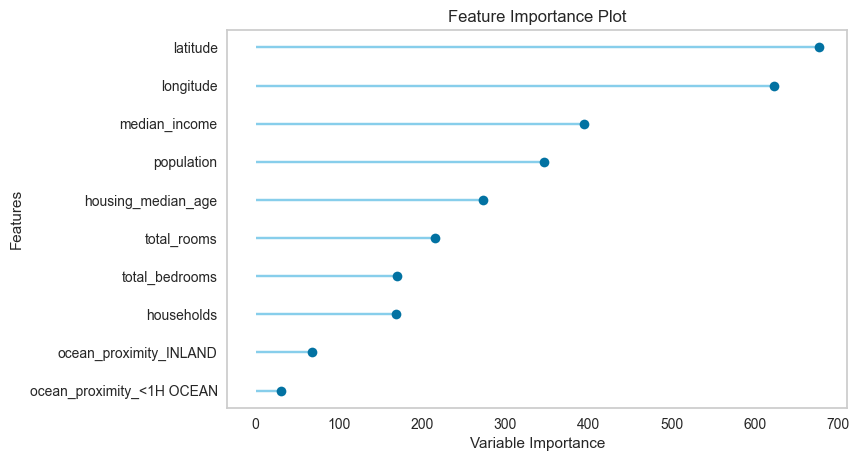

In [31]:
from pycaret.utils import check_metric

# Display feature and their importance
plot_model(tuned_LGBM, plot = 'feature')

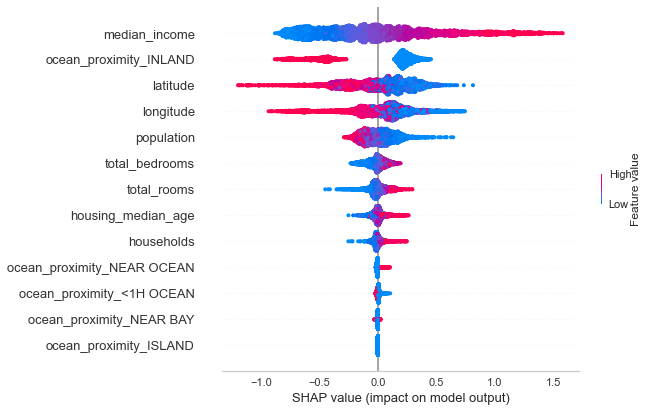

In [34]:
# Shap Model Interpretation Final Model
interpret_model(tuned_LGBM)

### Random Forest Regressor

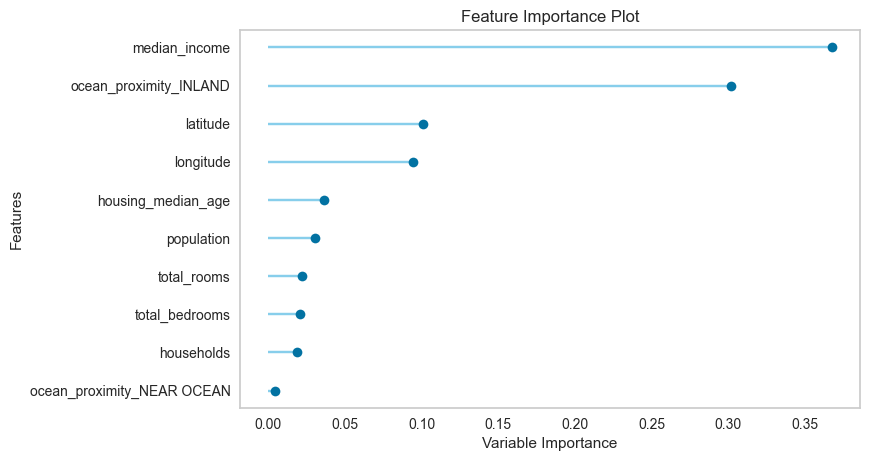

In [32]:
from pycaret.utils import check_metric

# Display feature and their importance
plot_model(RF, plot = 'feature')

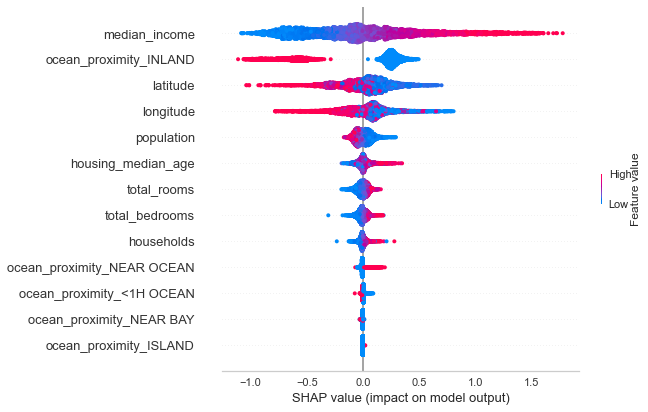

In [35]:
# Shap Model Interpretation Final Model
interpret_model(RF)

### Extra Trees Regressor

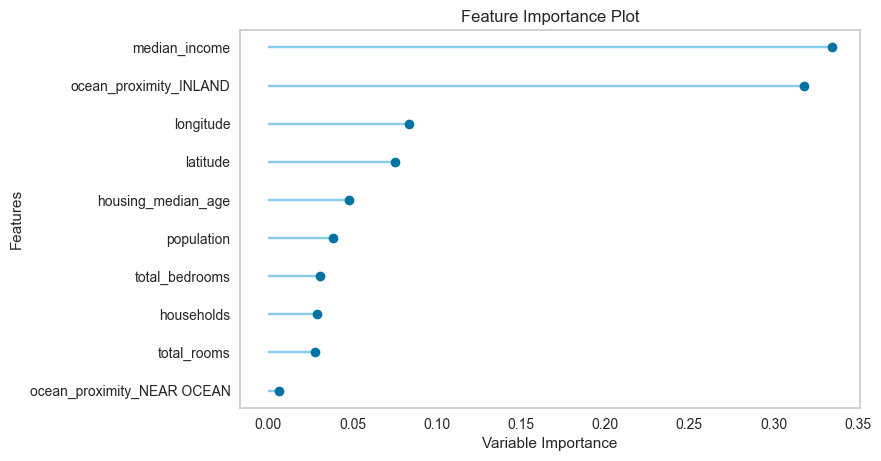

In [33]:
from pycaret.utils import check_metric

# Display feature and their importance
plot_model(ET, plot = 'feature')

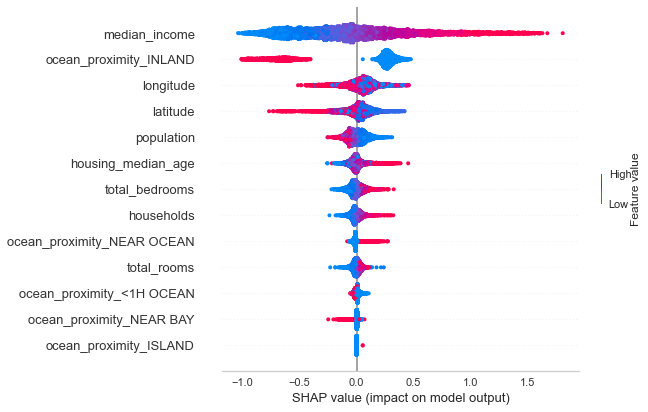

In [36]:
# Shap Model Interpretation Final Model
interpret_model(ET)

### Choosing The Best Model

In [37]:
best_model = tuned_LGBM
print(best_model)

PowerTransformedTargetRegressor(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=5...
                                                        importance_type='split',
                                                        learning_rate=0.1,
                                                        max_depth=-1,
                                                        min_child_samples=20,
                                                        min_child_weigh

### Predicting Model on Test / Hold Out Set

In [38]:
predict_model(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,32066.1978,2447851091.7492,49475.7627,0.8159,0.2343,0.1693


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,median_house_value,Label
0,-0.641161,1.189974,-1.052632,0.058005,-0.231214,-0.404278,-0.212963,0.912045,0.0,1.0,0.0,0.0,0.0,196300.0,210235.129315
1,-0.915567,0.802111,0.105263,0.715596,0.867052,0.775401,0.851852,0.609229,1.0,0.0,0.0,0.0,0.0,275000.0,260616.492068
2,-0.744063,1.137203,-0.736842,0.732761,0.184971,0.606417,0.185185,0.819343,0.0,1.0,0.0,0.0,0.0,127500.0,174316.947825
3,0.245383,-0.063324,-1.263158,2.842261,2.531792,2.865241,2.700617,0.525561,0.0,1.0,0.0,0.0,0.0,158900.0,175485.402483
4,-0.604222,0.474935,0.000000,-0.127257,-0.141618,-0.157219,-0.296296,-0.481492,1.0,0.0,0.0,0.0,0.0,87500.0,160509.808112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6188,-0.327176,0.630608,-0.526316,0.245635,0.080925,0.097326,0.024691,-0.291016,0.0,1.0,0.0,0.0,0.0,89500.0,86064.275758
6189,0.065963,-0.081794,-0.210526,-0.809115,-0.679191,-0.390374,-0.586420,-1.103674,1.0,0.0,0.0,0.0,0.0,100000.0,96013.612925
6190,0.340370,-0.295514,-0.894737,1.602841,1.500000,0.579679,1.672840,-0.310699,1.0,0.0,0.0,0.0,0.0,163300.0,183391.966835
6191,0.350924,-0.047492,-1.263158,-0.389464,-0.598266,-0.346524,-0.472222,0.618817,0.0,1.0,0.0,0.0,0.0,138100.0,146403.789875


### Residual Plot

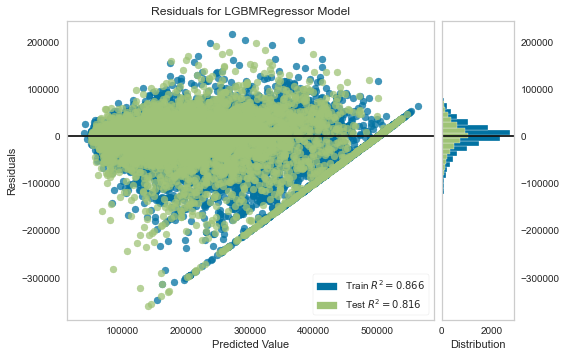

In [40]:
plot_model(tuned_LGBM)

### Predicting Error Plot

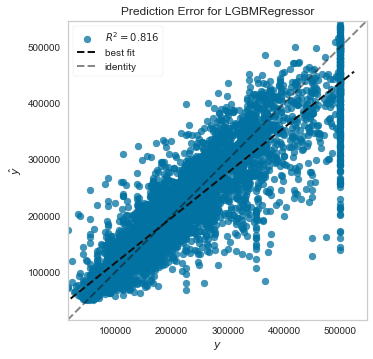

In [41]:
plot_model(tuned_LGBM, plot = 'error')

### Finalizing Best Model

In [42]:
final_model = finalize_model(best_model)
print(final_model)

PowerTransformedTargetRegressor(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=5...
                                                        importance_type='split',
                                                        learning_rate=0.1,
                                                        max_depth=-1,
                                                        min_child_samples=20,
                                                        min_child_weigh

### Predict Model on Unseen Data

In [43]:
# New Unseen Data
new_data = California.copy()
unseen_predictions = predict_model(final_model, data=new_data)
unseen_predictions

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,28423.7128,1880458743.2404,43364.2565,0.8588,0.2011,0.1474


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,Label
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,409355.928544
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,429290.211452
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,397195.055970
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,349804.962906
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,259958.456547
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,70591.482653
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,90950.968731
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,86751.904077
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,80341.559297


### `Ocean Proximity` Plotting In Respect to Target Feature `Median House Value`

Text(0.5, 1.0, 'Houses Prices Total per Proximity from the Ocean')

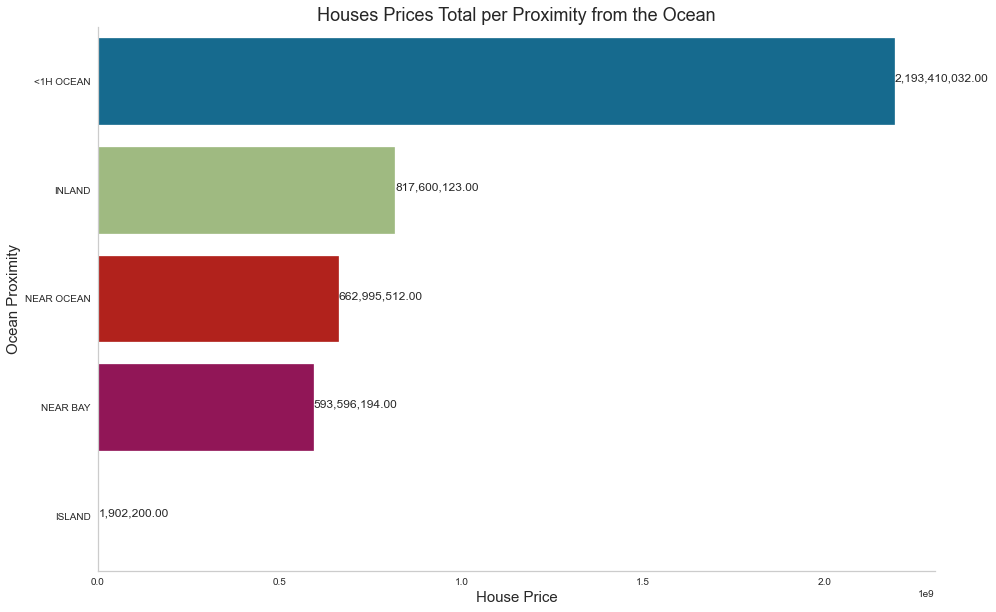

In [73]:
Cali_prox = pd.DataFrame(California.groupby('ocean_proximity', as_index=False)['median_house_value'].sum())
Cali_prox = Cali_prox.sort_values(by='median_house_value', ascending=False)

fig2=plt.figure(figsize=(15,10))
ax2 = sns.barplot(x='median_house_value', y='ocean_proximity', data=Cali_prox)
y2 = Cali_prox['median_house_value']
for i, v in enumerate(y2):
    ax2.text(v+5, i, '{:,.2f}' .format(v))
ax2.set_ylabel('Ocean Proximity',fontsize=15,fontweight='normal')    
ax2.set_xlabel('House Price',fontsize=15,fontweight='normal') 
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_title('Houses Prices Total per Proximity from the Ocean',fontsize=18, fontweight='normal')

### `Income` Plotting In Respect to Target Feature `Median House Value`

Text(0.5, 1.0, 'Houses Price per Income')

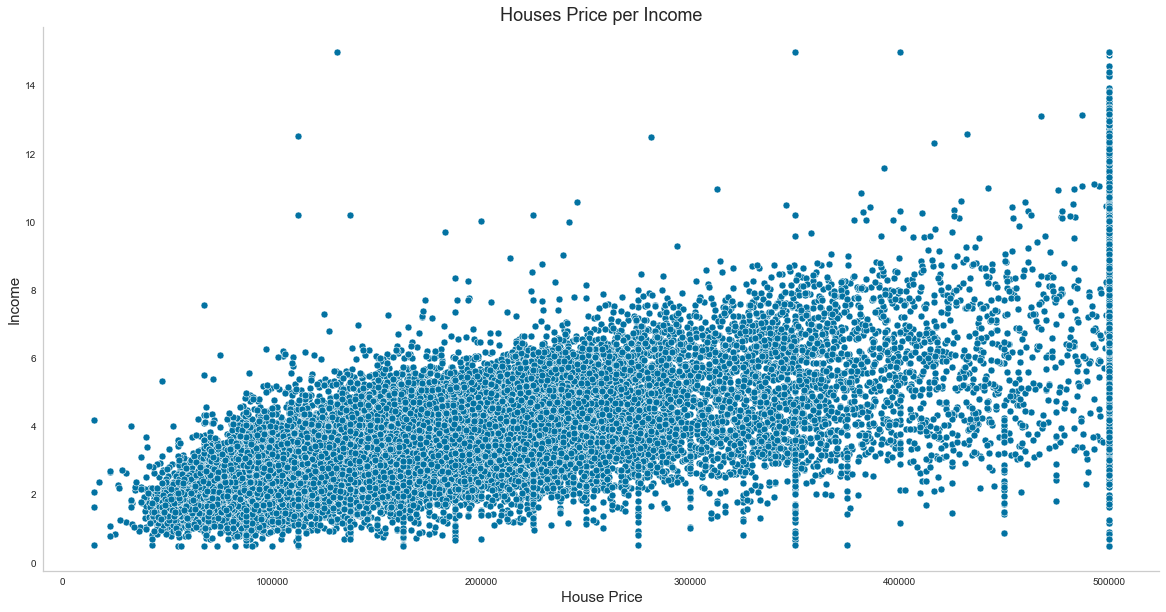

In [80]:
fig1=plt.figure(figsize=(20,10))
ax1 = sns.scatterplot(x='median_house_value', y='median_income', data=California, color='b')
ax1.set_ylabel('Income',fontsize=15,fontweight='normal')    
ax1.set_xlabel('House Price',fontsize=15,fontweight='normal') 
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_title('Houses Price per Income',fontsize=18, fontweight='normal')

### `Population` Plotting In Respect to Target Feature `Median House Value`

Text(0.5, 1.0, 'Houses Price per Areas Population')

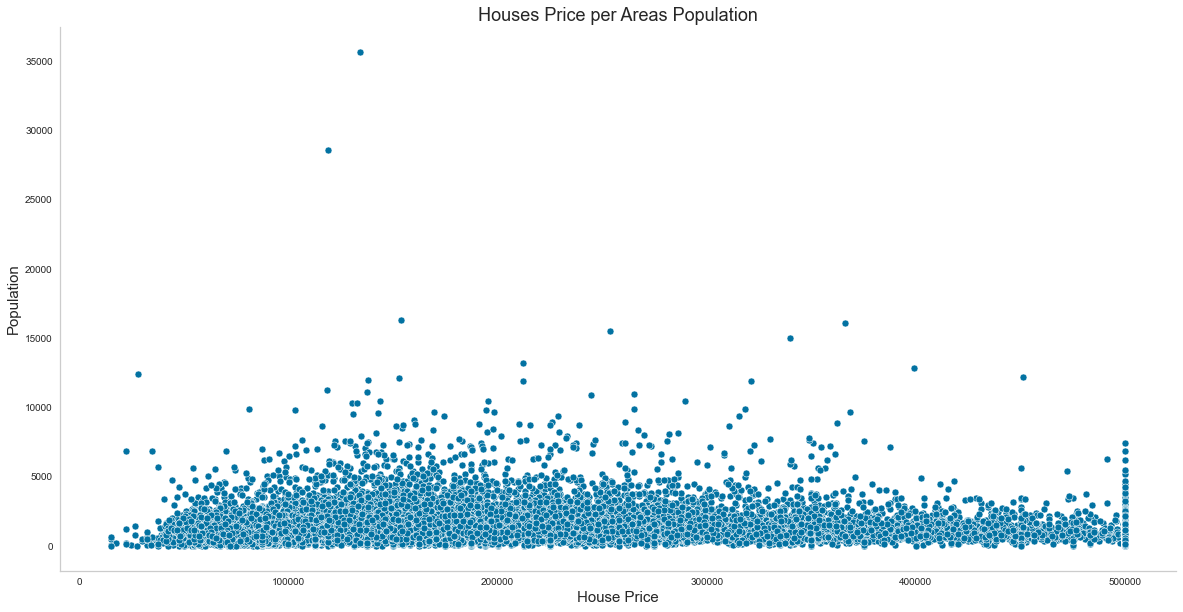

In [82]:
fig3=plt.figure(figsize=(20,10))
ax3 = sns.scatterplot(x='median_house_value', y='population', data=California, color='b')
ax3.set_ylabel('Population',fontsize=15,fontweight='normal')    
ax3.set_xlabel('House Price',fontsize=15,fontweight='normal') 
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_title('Houses Price per Areas Population',fontsize=18, fontweight='normal')